See https://www.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme/notebook

In [45]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Normalizer, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
#!pip install eli5
import eli5

In [46]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Read training and test sets, sort train set by session start time.

In [47]:
def show_confusion_matrix(y_true,y_pred,title='Confusionmatrix'):
    table=confusion_matrix(y_true,y_pred)
    fig,ax=plt.subplots(frameon=False)
    fig.set_size_inches(4,3)
    fig.suptitle(title,fontsize=20)
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    the_table=ax.table(cellText=table,
                        colWidths=[0.5]*len([0,1]),
                        rowLabels=['True 0','True 1'],colLabels=['Predicted 0','Predicted 1'],
                        cellLoc='center',rowLoc='center',loc="center")
    the_table.set_fontsize(34)
    the_table.scale(1,4)
    plt.show()

In [48]:
# Load websites dictionary
with open(r"../../../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)
    
# create an inverse id _> site mapping
site_dict = {v:k for (k, v) in site_dict.items()}
# we treat site with id 0 as "unknown"
site_dict[0] = 'unknown'




In [49]:
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv('../../../data/train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('../../../data/test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [50]:
# Transform data into format which can be fed into TfidfVectorizer
# This time we prefer to represent sessions with site names, not site ids. 
# It's less efficient but thus it'll be more convenient to interpret model weights.
sites = ['site%s' % i for i in range(1, 11)]
train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: ' '.join([site_dict[i] for i in row]), axis=1).tolist()
test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: ' '.join([site_dict[i] for i in row]), axis=1).tolist()

In [51]:
#test_sessions

In [52]:
#sites = ['site%s' % i for i in range(1, 11)]
#train_sessions.to_csv('train_sessions_text.txt', sep=' ', index=None, header=None)
#test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', sep=' ', index=None, header=None)

In [53]:
%%time
vectorizer_params={'ngram_range': (1, 5), 
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}
cv = TfidfVectorizer(**vectorizer_params)

#cv = TfidfVectorizer(ngram_range=(1, 3), max_features=25000, binary=True)


#with open('train_sessions_text.txt') as inp_train_file:
X_train = cv.fit_transform(train_sessions)
#with open('test_sessions_text.txt') as inp_test_file:
X_test = cv.transform(test_sessions)
X_train.shape, X_test.shape

CPU times: user 19.6 s, sys: 724 ms, total: 20.3 s
Wall time: 18.4 s


In [54]:
X_train.shape, X_test.shape

((253561, 50000), (82797, 50000))

#### Transform data into format which can be fed into CountVectorizer

In [55]:
#sites = ['site%s' % i for i in range(1, 11)]
#train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', sep=' ', index=None, header=None)
#test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', sep=' ', index=None, header=None)

In [56]:
#!head -5 train_sessions_text.txt

#### Fit TfidfVectorizer and transform data with it.

In [57]:
%%time
#cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
#cv = TfidfVectorizer(ngram_range=(1, 3), max_features=25000, binary=True)


#with open('train_sessions_text.txt') as inp_train_file:
#    X_train = cv.fit_transform(inp_train_file)
#with open('test_sessions_text.txt') as inp_test_file:
#    X_test = cv.transform(inp_test_file)
#X_train.shape, X_test.shape

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [58]:
#cv.get_feature_names()[:10]

In [59]:
X_train.shape, X_test.shape

((253561, 50000), (82797, 50000))

#### Save train targets into a separate vector.

In [60]:
y_train = train_df['target'].astype('int').values

#### We'll be performing time series cross-validation

We will be performing time series cross-validation, see sklearn TimeSeriesSplit and this dicussion on StackOverflow.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection

In [61]:
time_split = TimeSeriesSplit(n_splits=10)

In [62]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((23051,), (23051,)),
 ((46102,), (23051,)),
 ((69153,), (23051,)),
 ((92204,), (23051,)),
 ((115255,), (23051,)),
 ((138306,), (23051,)),
 ((161357,), (23051,)),
 ((184408,), (23051,)),
 ((207459,), (23051,)),
 ((230510,), (23051,))]

#### Perform time series cross-validation with logistic regression.

In [63]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='liblinear')

In [64]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='lbfgs', max_iter=8000)

In [71]:
logit2 = LogisticRegression(C=1, random_state=17, solver='lbfgs')

In [72]:
%%time
cv_scores = cross_val_score(logit2, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 35.3 ms, sys: 36.4 ms, total: 71.6 ms
Wall time: 5.07 s


In [74]:
cv_scores, cv_scores.mean() # 0.8627869686729444

(array([0.83422356, 0.6597167 , 0.85687482, 0.92823369, 0.84747829,
        0.88920157, 0.88863231, 0.87695964, 0.92042538, 0.92612373]),
 0.8627869686729444)

In [75]:
#eli5.show_weights(estimator=logit2, feature_names=cv.get_feature_names(), top=30)

#### Now we'll add some time features: indicators of morning, day, evening and night.

In [76]:
def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    X = hstack([X_sparse,
                morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1),
                evening.values.reshape(-1, 1),
                night.values.reshape(-1, 1)
                ])
    return X

In [77]:
%%time
X_train_new = add_time_features(train_df, X_train)
X_test_new = add_time_features(test_df, X_test)

CPU times: user 2.86 s, sys: 196 ms, total: 3.05 s
Wall time: 1.67 s


In [78]:
X_train_new.shape, X_test_new.shape

((253561, 50004), (82797, 50004))

In [79]:
X_train_new.mean(), X_train_new.min(), X_train_new.max()

(9.152322541019857e-05, 0.0, 1.0)

In [80]:
%%time
cv_scores = cross_val_score(logit2, X_train_new, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 112 ms, sys: 55.3 ms, total: 167 ms
Wall time: 6.02 s


In [82]:
cv_scores, cv_scores.mean() # 0.9215459232200187

(array([0.88338256, 0.81586133, 0.91885721, 0.96178195, 0.91527443,
        0.9521999 , 0.92850938, 0.94013706, 0.94672843, 0.95272698]),
 0.9215459232200187)

#### One hot encode the year-month

Not using, seems to lower the cv score

In [83]:
def add_month_categories_feature(df, X_sparse):
    foo = pd.DataFrame(index=df.index)
    foo['start_month_category'] = train_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('category')
    
    onehotencoder = OneHotEncoder(categories='auto')
    foo = onehotencoder.fit_transform(foo).toarray()

    X = hstack([X_sparse, foo])
    return X
    

In [84]:
%%time
X_train_newa = add_month_categories_feature(train_df, X_train_new)
X_test_newa = add_month_categories_feature(test_df, X_test_new)

CPU times: user 3.3 s, sys: 131 ms, total: 3.44 s
Wall time: 2.34 s


In [85]:
X_train_newa.shape, X_test_newa.shape

((253561, 50020), (82797, 50020))

In [86]:
%%time
cv_scores = cross_val_score(logit2, X_train_newa, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 831 ms, sys: 63.9 ms, total: 895 ms
Wall time: 6.47 s


In [87]:
cv_scores, cv_scores.mean() # DOWN from 0.9265697731091509

(array([0.86852977, 0.81858706, 0.88176327, 0.96367722, 0.91592564,
        0.95074886, 0.92654203, 0.93803183, 0.9299465 , 0.95409206]),
 0.9147844243864075)

#### Add start month feature

In [88]:
def add_start_month_feature(df, X_sparse):
    foo = pd.DataFrame(index=df.index)
    bar = df['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype('float64')
    foo['scaled_month'] = StandardScaler().fit_transform(bar.values.reshape(-1, 1))
    #foo['scaled_month'] = MinMaxScaler().fit_transform(bar.values.reshape(-1, 1))
    
    X = hstack([X_sparse, foo])
    return X

In [89]:
%%time
X_train_new2 = add_start_month_feature(train_df, X_train_new)
X_test_new2 = add_start_month_feature(test_df, X_test_new)

CPU times: user 2.71 s, sys: 50.4 ms, total: 2.76 s
Wall time: 1.61 s


In [90]:
X_train_new2.shape, X_test_new2.shape

((253561, 50005), (82797, 50005))

In [91]:
X_train_new2.mean(), X_train_new2.min(), X_train_new2.max()

(9.152139512871967e-05, -1.7444049642540242, 1.0)

In [92]:
%%time
cv_scores = cross_val_score(logit2, X_train_new2, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 530 ms, sys: 56.4 ms, total: 586 ms
Wall time: 6.59 s


In [94]:
cv_scores, cv_scores.mean() # 0.9242053832079945

(array([0.88043826, 0.81921512, 0.94492134, 0.96358604, 0.91575655,
        0.95197229, 0.92757155, 0.93944622, 0.9462855 , 0.95286096]),
 0.9242053832079945)

#### Add session length feature

In [95]:
def add_session_length_feature(df, X_sparse):    
    foo = pd.DataFrame(index=df.index)
    foo['min_seconds'] = df[times].min(axis=1)
    foo['max_seconds'] = df[times].max(axis=1)
    foo['seconds'] = (foo['max_seconds'] - foo['min_seconds']) / np.timedelta64(1, 's')

    foo['scaled_session_duration_seconds'] = MinMaxScaler().fit_transform(foo['seconds'].values.reshape(-1, 1))
    #foo['scaled_session_duration_seconds'] = StandardScaler().fit_transform(foo['seconds'].values.reshape(-1, 1))
    
    #foo['lt_40_secs'] = (foo['seconds'] < 40)
    #foo['lt_40_secs'] = foo['lt_40_secs'].astype('float64')
    
    foo = foo.drop(columns=['min_seconds', 'max_seconds', 'seconds'])
    
    X = hstack([X_sparse, foo])
    return X
    #return foo

In [96]:
%%time
X_train_new3 = add_session_length_feature(train_df, X_train_new2)
X_test_new3 = add_session_length_feature(test_df, X_test_new2)

CPU times: user 623 ms, sys: 68.1 ms, total: 691 ms
Wall time: 189 ms


In [97]:
X_train_new3.shape, X_test_new3.shape

((253561, 50006), (82797, 50006))

In [98]:
%%time
cv_scores = cross_val_score(logit2, X_train_new3, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 134 ms, sys: 68.4 ms, total: 202 ms
Wall time: 6.77 s


In [100]:
cv_scores, cv_scores.mean() # 0.9246847402551401

(array([0.87529575, 0.82225939, 0.94558636, 0.9635361 , 0.91635363,
        0.95341755, 0.92925739, 0.94042592, 0.94769185, 0.95302345]),
 0.9246847402551401)

In [101]:
#logit2.fit(X_train_new3, y_train)

In [102]:
#show_confusion_matrix(y_train, logit2.predict(X_train_new3))

#### Add social network features

In [ ]:
#facebook_ids = []
#youtube_ids = []
#google_video_ids = []
#nih_ids = []
#gmail_ids = []
#annotathon_ids = []
#bing_ids = []
#phylogeny_ids = []
#oracle_ids = []

##print(site_dict.values())
#
#for key in list(site_dict.keys()):
#    if 'facebook' in key:
#        facebook_ids.append(site_dict[key])
#    if 'youtube' in key or 'ytimg' in key:
#        youtube_ids.append(site_dict[key])
#    if 'googlevideo.com' in key:
#        google_video_ids.append(site_dict[key])
#    if 'nih.gov' in key:
#        nih_ids.append(site_dict[key])
#    if 'mail.google.com' in key:
#        gmail_ids.append(site_dict[key])
##    if 'annotathon.org' in key:
#        annotathon_ids.append(site_dict[key])
#    if 'bing.com' == key:
#        bing_ids.append(site_dict[key])
#    if 'phylogeny.fr' in key:
#        phylogeny_ids.append(site_dict[key])
#    if 'javadl-esd-secure.oracle.com' in key or 'download.jboss.org' in key:
#        oracle_ids.append(site_dict[key])
        
##print(youtube_ids)



In [166]:
facebook_ids = []
youtube_ids = []
google_video_ids = []
nih_ids = []
gmail_ids = []
annotathon_ids = []
bing_ids = []
phylogeny_ids = []
oracle_ids = []

#print(site_dict.values())

for key in list(site_dict.keys()):
    if 'facebook' in site_dict[key]:
        facebook_ids.append(key)
    if 'youtube' in site_dict[key] or 'ytimg' in site_dict[key]:
        youtube_ids.append(key)
    if 'googlevideo.com' in site_dict[key]:
        google_video_ids.append(key)
    if 'nih.gov' in site_dict[key]:
        nih_ids.append(key)
    if 'mail.google.com' in site_dict[key]:
        gmail_ids.append(key)
    if 'annotathon.org' in site_dict[key]:
        annotathon_ids.append(key)
    if 'bing.com' == site_dict[key]:
        bing_ids.append(key)
    if 'phylogeny.fr' in site_dict[key]:
        phylogeny_ids.append(key)
    if 'javadl-esd-secure.oracle.com' in site_dict[key] or 'download.jboss.org' in site_dict[key]:
        oracle_ids.append(key)
        
#print(youtube_ids)



In [167]:
def is_site(x, l):
    if x in l:
      return 1 
    return 0

def is_long_session(x):
    if x < 3:
        return 0
    elif x < 5:
        return 1
    elif x < 10:
        return 2
    elif x < 30:
        return 3
    elif x < 40:
        return 4
    return 5

In [173]:
def add_social_network_feature(df, X_sparse):
    #return X_sparse # TODO fix this

    foo = pd.DataFrame(index=df.index)
    
    foo['time1'] = df[['time1']].apply(pd.to_datetime)
    # TODO should not fillna, instead find the last date
    foo['time10'] = df[['time10']].fillna('2014-02-20 10:02:45').apply(pd.to_datetime)
    
    
    foo['yb start'] = df['site1'].apply(lambda x: is_site(x, youtube_ids))
    foo['fb start'] = df['site1'].apply(lambda x: is_site(x, facebook_ids))
    foo['nih start'] = df['site1'].apply(lambda x: is_site(x, nih_ids))
    foo['gmail start'] = df['site1'].apply(lambda x: is_site(x, gmail_ids))
    foo['annotathon start'] = df['site1'].apply(lambda x: is_site(x, annotathon_ids))
    foo['bing start'] = df['site1'].apply(lambda x: is_site(x, bing_ids))
    foo['phylogeny start'] = df['site1'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['oracle start'] = df['site1'].apply(lambda x: is_site(x, oracle_ids))
    

    ##foo['google video start'] = df['site1'].apply(lambda x: is_site(x, google_video_ids))

    foo['oracle start2'] = df['site2'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start3'] = df['site3'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start4'] = df['site4'].apply(lambda x: is_site(x, oracle_ids))
    foo['oracle start5'] = df['site5'].apply(lambda x: is_site(x, oracle_ids))

    foo['gmail start2'] = df['site2'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start3'] = df['site3'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start4'] = df['site4'].apply(lambda x: is_site(x, gmail_ids))
    foo['gmail start5'] = df['site5'].apply(lambda x: is_site(x, gmail_ids))
    
    foo['bing start2'] = df['site2'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start3'] = df['site3'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start4'] = df['site4'].apply(lambda x: is_site(x, bing_ids))
    foo['bing start5'] = df['site5'].apply(lambda x: is_site(x, bing_ids))
    
    foo['phylogeny start2'] = df['site2'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start3'] = df['site3'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start4'] = df['site4'].apply(lambda x: is_site(x, phylogeny_ids))
    foo['phylogeny start5'] = df['site5'].apply(lambda x: is_site(x, phylogeny_ids))
    
    foo['nih start2'] = df['site2'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start3'] = df['site3'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start4'] = df['site4'].apply(lambda x: is_site(x, nih_ids))
    foo['nih start5'] = df['site5'].apply(lambda x: is_site(x, nih_ids))

    
    foo['annotathon start2'] = df['site2'].apply(lambda x: is_site(x, annotathon_ids))
    foo['annotathon start3'] = df['site3'].apply(lambda x: is_site(x, annotathon_ids))
    foo['annotathon start4'] = df['site4'].apply(lambda x: is_site(x, annotathon_ids))
    foo['annotathon start5'] = df['site5'].apply(lambda x: is_site(x, annotathon_ids))
    
    
    foo['yb end'] = df['site10'].apply(lambda x: is_site(x, youtube_ids))
    foo['fb end'] = df['site10'].apply(lambda x: is_site(x, facebook_ids))
    foo['nih end'] = df['site10'].apply(lambda x: is_site(x, nih_ids))
    foo['gmail end'] = df['site10'].apply(lambda x: is_site(x, gmail_ids))
    foo['annotathon end'] = df['site10'].apply(lambda x: is_site(x, annotathon_ids))
    foo['bing end'] = df['site10'].apply(lambda x: is_site(x, bing_ids))
    ##foo['google video end'] = df['site10'].apply(lambda x: is_site(x, google_video_ids))

    
    # TODO can remove?
    #foo['start day'] = foo['time1'].apply(pd.datetime.weekday)
    

    # Monday=0, Sunday=6
    # Alice is rarely seen on Wednesday
    #foo['day_of_week'] = df['time1'].apply(lambda ts: ts.dayofweek).astype('int')
    #foo['is_wednesday'] = (foo['day_of_week'] == 2).astype('int')
    
    # Use the second one if used
    #foo['duration'] = (foo['time10'] - foo['time1']).astype(int).apply(lambda x: x/10e8)
    #foo['duration'] = foo['duration'].apply(is_long_session).astype(int)
    
    foo = foo.drop(columns=['time1', 'time10'])
    
    X = hstack([X_sparse, foo])
    return X

In [174]:
%%time
X_train_new4 = add_social_network_feature(train_df, X_train_new3)
X_test_new4 = add_social_network_feature(test_df, X_test_new3)

CPU times: user 10.8 s, sys: 241 ms, total: 11 s
Wall time: 9.89 s


In [175]:
X_train_new4.shape, X_test_new4.shape

((253561, 50044), (82797, 50044))

In [176]:
%%time
cv_scores = cross_val_score(logit2, X_train_new4, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=4)

CPU times: user 831 ms, sys: 67.1 ms, total: 898 ms
Wall time: 6.9 s


In [177]:
cv_scores, cv_scores.mean() # 0.9259448233290841

(array([0.87453871, 0.8247949 , 0.94595466, 0.9653923 , 0.91821096,
        0.95371374, 0.93448543, 0.94033227, 0.94833341, 0.95369186]),
 0.9259448233290841)

In [178]:
logit2.fit(X_train_new4, y_train)

/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

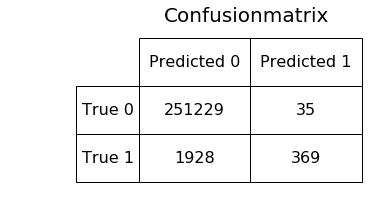

In [179]:
show_confusion_matrix(y_train, logit2.predict(X_train_new4))

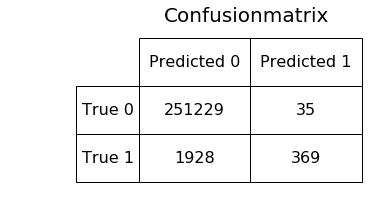

In [180]:
show_confusion_matrix(y_train, logit2.predict(X_train_new4))

#### Now we tune regularization parameter C.

In [181]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='lbfgs', max_iter=8000)

In [182]:
#logit2 = LogisticRegression(C=1, random_state=17, solver='liblinear')

In [183]:
#c_values = np.logspace(-2, 2, 10)

params = {
    'C': np.logspace(-2, 2, 20)
#    'penalty': ['l1','l2']
}

logit_grid_searcher = GridSearchCV(estimator=logit2, param_grid=params,
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)
#logit_grid_searcher = GridSearchCV(estimator=logit2, param_grid={'C': c_values},
#                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

In [184]:
%%time
logit_grid_searcher.fit(X_train_new4, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: 

/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.


/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.


CPU times: user 25min 51s, sys: 8.68 s, total: 25min 59s
Wall time: 4min 29s


/Users/wtf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'C': array([1.00000e-02, 1.62378e-02, 2.63665e-02, 4.28133e-02, 6.95193e-02,
       1.12884e-01, 1.83298e-01, 2.97635e-01, 4.83293e-01, 7.84760e-01,
       1.27427e+00, 2.06914e+00, 3.35982e+00, 5.45559e+00, 8.85867e+00,
       1.43845e+01, 2.33572e+01, 3.79269e+01, 6.15848e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [185]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_ # 0.9285726252378963

(0.9285726252378963, {'C': 3.359818286283781})

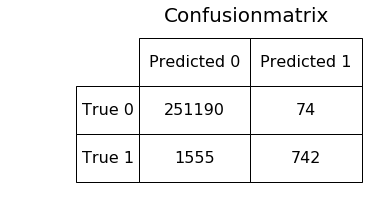

In [186]:
show_confusion_matrix(y_train, logit_grid_searcher.predict(X_train_new4))

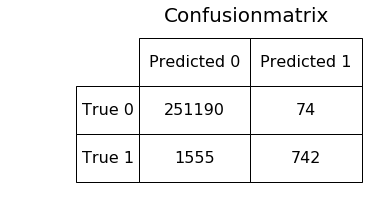

In [187]:
show_confusion_matrix(y_train, logit_grid_searcher.predict(X_train_new4))

In [188]:
logit_test_pred3 = logit_grid_searcher.predict_proba(X_test_new4)[:, 1]
write_to_submission_file(logit_test_pred3, 'submissions/19-subm1.csv') # 0.95081
